In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import jax.numpy as jnp
import jax
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
import seaborn as sns
import pickle
import copy

import src.metrics as metrics
import src.kernels as kernels
import src.bootstrap as boot
import src.exp_utils as exp_utils
import experiments.kef as exp_kef
import experiments.efm as exp_efm

In [19]:
np.random.seed(2024)

X = np.reshape(np.linspace(-5., 5, 1001), (-1,))
lp = [kef.log_unnormalised_density(xx) for xx in X]

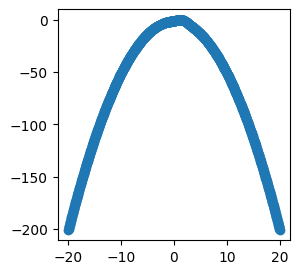

In [20]:
_, ax = plt.subplots(figsize=(3,3))

ax.scatter(X, lp)

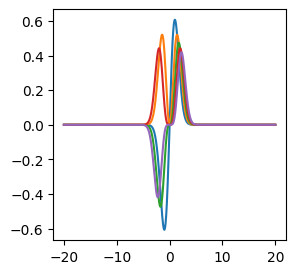

In [38]:
_, ax = plt.subplots(figsize=(3, 3))

phi_vals = np.array([kef.t(x) for x in X])
for l in range(phi_vals.shape[-1]):
    ax.plot(X, phi_vals[:, l])

In [42]:
x = X[400]
jnp.atleast_2d(jax.jacfwd(kef.t)(x))

Array([[-0.00503194,  0.01328365, -0.02848603,  0.0525896 , -0.08623553]],      dtype=float32)

In [57]:
import experiments.efm as exp_efm

efm_model = exp_efm.EFM(np.ones((2,)) * 0.)

x = jnp.array([-.1, .2, 0.3, 0.2, -0.7])
score_approx = jnp.atleast_2d(jax.jacfwd(efm_model.log_unnormalised_density)(x))
print("score_approx", score_approx)

x = jnp.array([[-.1, .2, 0.3, 0.2, -0.7]])
score_exact, _ = efm_model.compute_grad_and_hvp(x)
print("score_exact", score_exact)

JT_approx = jax.jacfwd(efm_model.t)(x)
JT_exact, _, _ = efm_model._compute_grads(x)
print("JT_approx", JT_approx)
print("JT_exact", JT_exact)

score_approx [[ 0.18       -0.26       -0.32000002 -0.22        0.68      ]]
score_exact [[ 0.18       -0.26       -0.32000002 -0.22        0.68      ]]
JT_approx [[[[0.        0.        0.        0.961043  0.       ]]

  [[0.        0.        0.        0.        0.6347395]]]]
JT_exact [[[0.        0.        0.        0.961043  0.       ]
  [0.        0.        0.        0.        0.6347396]]]


In [66]:
x = np.random.normal(size=(100, 5))

JT = jax.vmap(lambda x: jax.jacfwd(efm_model.t)(x))(x)

In [70]:
x = np.random.normal(size=(100, 1))

JT = jax.vmap(lambda x: jax.jacfwd(kef.t)(x))(x)
JT.shape

(100, 5, 1)

In [31]:
ys, unnormalize = exp_kef.load_galaxies("../data/kef/galaxies.rda")

# standardise
# ys /= ys.std()

/home/ma/x/xl6116/.envs/robust/lib/python3.8/site-packages/rdata/parser/_parser.py:839: UserWarning: Tag not implemented for type RObjectType.CHAR and ignored
  warnings.warn(
/home/ma/x/xl6116/.envs/robust/lib/python3.8/site-packages/rdata/parser/_parser.py:839: UserWarning: Tag not implemented for type RObjectType.REAL and ignored
  warnings.warn(


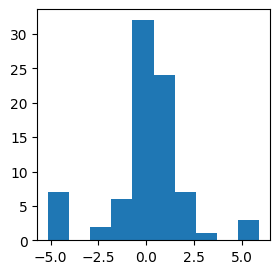

In [32]:
_, ax = plt.subplots(figsize=(3,3))

_ = ax.hist(np.squeeze(ys))

In [33]:
np.random.seed(2024)

level_exp = True

if level_exp:
    add_outliers = True
    eps = 0.
    ol_mean = 10.
    ol_std = .1
    # L = 25
    L = 1 #!
else:
    add_outliers = False # True
    eps = 0.3
    ol_mean = 1. # 0.
    ol_std = 1. # 1.
    L = 1

split = True

# 1. pure data
X = np.reshape(ys, (-1, 1))

# split
if split:
    n = X.shape[0]
    ntest = int(.5 * n)
    idx = np.random.choice(range(n), size=ntest, replace=False)
    X_test_raw = X[idx]
    X = X[jnp.array([i for i in range(n) if i not in idx])]
else:
    X_test_raw = X

# 2. contam data
if add_outliers:
    X = exp_efm.sample_outlier_contam(X, eps=eps, ol_mean=ol_mean, ol_std=ol_std)

In [44]:
kef_l = jnp.sqrt(2)
kef_p0_std = 3.0
# kef_l = jnp.sqrt(.2) #!
# kef_p0_std = 2. # 3.0 #!
p0_loc = 0.
params = np.ones((L,))
kef = exp_kef.KernelExpFamily(params=params, bw=kef_l, L=L, p0_loc=p0_loc, p0_scale=kef_p0_std)

In [49]:
# kernel = kernels.SumKernel([kernels.IMQ(sigma_sq=2*l**2) for l in [0.6, 1.0, 1.2]])
# kernel = kernels.IMQ(med_heuristic=True, X=X, Y=X)
# kernel = kernels.IMQ(sigma_sq=2*1**2, X=X, Y=X)

# poly_weight_fn = kernels.PolyWeightFunction(a=X.std())
poly_weight_fn = kernels.PolyWeightFunction(a=1.)
kernel0 = kernels.IMQ(sigma_sq=2*1.**2, X=X, Y=X)
kernel = kernels.TiltedKernel(kernel=kernel0, weight_fn=poly_weight_fn)

est_params = kef.ksd_est(X, kernel)
print("est_params", est_params)

est_params [-0.06193496]


In [61]:
est_params = jnp.array([5.])
trained_kef_model = exp_kef.KernelExpFamily(est_params, bw=kef_l, L=L, p0_loc=0., p0_scale=kef_p0_std)

In [62]:
seed = jax.random.PRNGKey(seed=56789)

X_plot = np.reshape(np.linspace(-10., 10., 1001), (-1, 1))
approx_prob = trained_kef_model.approx_prob(seed, xs=X_plot, n_samples=2000)

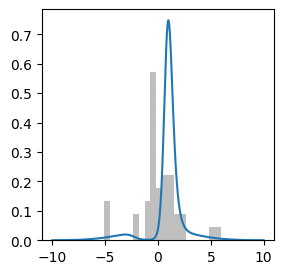

In [63]:
# contam
_, ax = plt.subplots(figsize=(3,3))

# ax.hist(np.squeeze(ys), density=True)
ax.hist(X.reshape(-1), color="grey", alpha=0.5, bins=20, density=True)
ax.plot(X_plot, approx_prob)
# ax.set_xlim(-10., 10.)

In [823]:
xx = jnp.array([1., 2., 10.])
phi1 = jax.vmap(lambda x: exp_kef.phi(x, trained_kef_model.bw, trained_kef_model.L))(xx)
phi1

Array([[5.2026010e-01, 5.2026010e-01, 4.2479062e-01, 3.0037233e-01,
        1.8997213e-01, 1.0968045e-01, 5.8626674e-02, 2.9313335e-02,
        1.3818438e-02, 6.1797933e-03, 2.6350729e-03, 1.0757641e-03,
        4.2194937e-04, 1.5948186e-04, 5.8234538e-05, 2.0589017e-05,
        7.0619753e-06, 2.3539919e-06, 7.6373578e-07, 2.4151444e-07],
       [5.1804449e-02, 1.0360890e-01, 1.6919264e-01, 2.3927452e-01,
        3.0266097e-01, 3.4948277e-01, 3.7361282e-01, 3.7361279e-01,
        3.5224551e-01, 3.1505796e-01, 2.6868233e-01, 2.1937822e-01,
        1.7209445e-01, 1.3009116e-01, 9.5005147e-02, 6.7178778e-02,
        4.6084266e-02, 3.0722845e-02, 1.9935613e-02, 1.2608388e-02],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.000000

In [640]:
phi2 = jax.vmap(lambda x: exp_kef.phi(x, trained_kef_model.bw, trained_kef_model.L))(xx)
phi2

Array([[6.0653067e-01, 4.2888191e-01, 2.4761507e-01, 1.2380755e-01,
        5.5368405e-02, 2.2604052e-02, 8.5435314e-03, 3.0205937e-03,
        1.0068646e-03, 3.1839876e-04, 9.6000716e-05, 2.7713013e-05,
        7.6862079e-06, 2.0542257e-06, 5.3039889e-07, 1.3259972e-07,
        3.2160120e-08, 7.5802218e-09, 1.7390188e-09, 3.8885661e-10,
        8.4855518e-11, 1.8091265e-11, 3.7722893e-12, 7.7001502e-13,
        1.5400299e-13],
       [2.7067056e-01, 3.8278598e-01, 4.4200313e-01, 4.4200319e-01,
        3.9533961e-01, 3.2279336e-01, 2.4400893e-01, 1.7254032e-01,
        1.1502687e-01, 7.2749391e-02, 4.3869525e-02, 2.5328062e-02,
        1.4049491e-02, 7.5097657e-03, 3.8780291e-03, 1.9390136e-03,
        9.4055908e-04, 4.4338452e-04, 2.0343829e-04, 9.0980451e-05,
        3.9707131e-05, 1.6931193e-05, 7.0607921e-06, 2.8825534e-06,
        1.1530219e-06],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,


In [641]:
jnp.allclose(phi1, phi2)

Array(True, dtype=bool)

In [644]:
grads1 = trained_kef_model._compute_grads(xx)
grads1

(Array([[ 8.3057245e-08,  4.2888194e-01,  4.9523014e-01,  3.7142262e-01,
          2.2147363e-01,  1.1302028e-01,  5.1261179e-02,  2.1144159e-02,
          8.0549167e-03,  2.8655867e-03,  9.6000754e-04,  3.0484336e-04,
          9.2234535e-05,  2.6704944e-05,  7.4255845e-06,  1.9889958e-06,
          5.1456249e-07,  1.2886375e-07,  3.1302392e-08,  7.3882842e-09,
          1.6971112e-09,  3.7991657e-10,  8.2990358e-11,  1.7710351e-11,
          3.6960730e-12],
        [-4.0600577e-01, -3.8278592e-01, -2.2100152e-01,  9.0617092e-08,
          1.9766992e-01,  3.2279348e-01,  3.6601335e-01,  3.4508070e-01,
          2.8756723e-01,  2.1824814e-01,  1.5354334e-01,  1.0131233e-01,
          6.3222706e-02,  3.7548847e-02,  2.1329151e-02,  1.1634082e-02,
          6.1136386e-03,  3.1036884e-03,  1.5257890e-03,  7.2784384e-04,
          3.3751063e-04,  1.5238060e-04,  6.7077490e-05,  2.8825545e-05,
          1.2106728e-05],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,

In [643]:
grads2 = trained_kef_model._compute_grads(xx)
grads2

(Array([[ 3.61520449e-08,  4.28881913e-01,  4.95230138e-01,
          3.71422648e-01,  2.21473619e-01,  1.13020256e-01,
          5.12611866e-02,  2.11441554e-02,  8.05491675e-03,
          2.86558876e-03,  9.60007193e-04,  3.04843154e-04,
          9.22344916e-05,  2.67049327e-05,  7.42558450e-06,
          1.98899579e-06,  5.14561918e-07,  1.28863775e-07,
          3.13023385e-08,  7.38827577e-09,  1.69711034e-09,
          3.79916543e-10,  8.29903646e-11,  1.77103453e-11,
          3.69607166e-12],
        [-4.06005800e-01, -3.82785916e-01, -2.21001506e-01,
          5.26908863e-08,  1.97669849e-01,  3.22793394e-01,
          3.66013408e-01,  3.45080644e-01,  2.87567168e-01,
          2.18248174e-01,  1.53543338e-01,  1.01312250e-01,
          6.32227063e-02,  3.75488289e-02,  2.13291608e-02,
          1.16340816e-02,  6.11363398e-03,  3.10369162e-03,
          1.52578717e-03,  7.27843610e-04,  3.37510603e-04,
          1.52380744e-04,  6.70775262e-05,  2.88255342e-05,
          1.2

#### Test

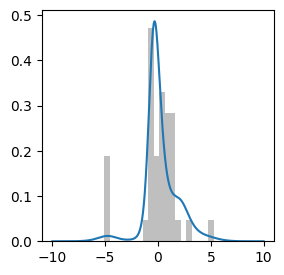

In [169]:
# add_outliers_test = True
# eps = 0.2
# ol_mean = 0.

add_outliers_test = False

if not add_outliers_test:
    X_test = X_test_raw
    
else:
    if add_outliers:
        X_test = exp_efm.sample_outlier_contam(X_test_raw, eps=eps, ol_mean=ol_mean, ol_std=0.1)
    else:
        X_test = X_test_raw
# X_test = X_test[X_test < 7.].reshape((-1, 1))

score = jax.vmap(trained_kef_model.score)(X_test)

_, ax = plt.subplots(figsize=(3,3))
ax.hist(X_test.reshape(-1), color="grey", alpha=0.5, bins=20, density=True)
ax.plot(X_plot, approx_prob)

In [170]:
# # np.random.seed(321)

# # test_kernel = kernel
# # test_kernel = kernels.IMQ(sigma_sq=2*1**2, X=X, Y=X)

# # poly_weight_fn = kernels.PolyWeightFunction(a=X.std())
# poly_weight_fn = kernels.PolyWeightFunction(a=1.)
# kernel0 = kernels.IMQ(sigma_sq=2*1.**2)
# test_kernel = kernels.TiltedKernel(kernel=kernel0, weight_fn=poly_weight_fn)

# ksd = metrics.KSD(test_kernel)
# wild_boot = boot.WildBootstrap(ksd)
# pval, stat, boot_stats = wild_boot.pval(X_test, X_test, return_stat=True, return_boot=True, score=score, hvp=None)
# pval

In [171]:
# weight_fn_args = {"a": X.std()}
weighted_score_sup = 1/jnp.sqrt(2) * jnp.exp(-0.5)
weight_fn_args = {"weighted_score_sup": weighted_score_sup}
theta = 0.000001**0.5

X_test_b = jnp.reshape(X_test, (1, -1, 1))
score_b = jnp.reshape(score, (1, -1, 1))
test_res = exp_utils.run_tests(
    samples=X_test_b, scores=score_b, hvps=None, hvp_denom_sup=None, 
    theta=theta, bw=2.*1**2, alpha=0.05, verbose=True, base_kernel="IMQ", weight_fn_args=weight_fn_args,
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.84s/it]


In [172]:
print("standard", test_res["standard"]["rej"])
print("tilted", test_res["tilted"]["rej"])
print("boot", test_res["tilted_r_boot"]["rej"])

standard [0]
tilted [0]
boot [0]


In [824]:
print("stat", test_res["tilted_robust_boot"]["stat"])
print("threshold", test_res["tilted_robust_boot"]["threshold"])
print("tilted pval", test_res["tilted"]["pval"])
print("tau", test_res["tilted_robust_dev"]["tau"])

stat [Array(0.03147333, dtype=float32)]
threshold [Array(0.22952138, dtype=float32)]
tilted pval [Array(0.48151848, dtype=float32, weak_type=True)]
tau [Array(2.5417037, dtype=float32)]


In [813]:
print("stat", test_res["standard"]["stat"])

stat [Array(0.03222534, dtype=float32)]


Array(0.02333739, dtype=float32)

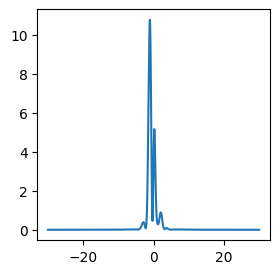

In [786]:
# find tau
xx = jnp.linspace(-30., 30., 1001).reshape((-1, 1))
ss = jax.vmap(trained_kef_model.score)(xx)

# test_kernel = kernels.IMQ(sigma_sq=2*1**2, X=X, Y=X)

poly_weight_fn = kernels.PolyWeightFunction(a=1.)
kernel0 = kernels.IMQ(sigma_sq=2*1.**2)
test_kernel = kernels.TiltedKernel(kernel=kernel0, weight_fn=poly_weight_fn)

ksd = metrics.KSD(test_kernel)
ksd_mat = ksd(xx, xx, score=ss, vstat=True, output_dim=2)
ksd_vals = jnp.diag(ksd_mat)

_, ax = plt.subplots(figsize=(3,3))
_ = plt.plot(xx.reshape(-1), ksd_vals)

tau = jnp.max(ksd_vals[jnp.reshape(jnp.logical_or(xx > 8., xx < -8.), -1)])
tau

In [787]:
# theta_new = 0.01 * test_res["tilted_robust_dev"]["tau"][0]**0.5
theta_new = 0.1 * tau **0.5
test_res_new = copy.deepcopy(test_res)
test_res_new = exp_utils.change_theta(test_res, ["tilted_robust_dev", "tilted_robust_clt", "tilted_robust_boot"], theta_new)

print("standard", test_res["standard"]["rej"])
print("tilted", test_res["tilted"]["rej"])
print("dev", test_res["tilted_robust_dev"]["rej"])
print("boot", test_res["tilted_robust_boot"]["rej"])

standard [0]
tilted [0]
dev [0]
boot [0]


In [788]:
theta_new**2

Array(0.00023337, dtype=float32)

#### use code from Key et al 

In [425]:
from src.kcomp.bootstrapped_tests import (
    Bootstrap,
    parametric_bootstrap_test,
    wild_bootstrap_test,
)

from src.kcomp.distributions.kef import kernel_exp_family
from src.kcomp.kernels import IMQKernel, SumKernel
from src.kcomp.ksd import KSDAnalyticEstimator, KSDStatistic
from src.kcomp.rejection_sampler import LowAcceptanceError

from experiments.efm import sample_outlier_contam

In [346]:
# 1. pure data
X = ys

# 2. contam data
# X = sample_outlier_contam(ys, eps=0.1, ol_mean=5., ol_std=0.1)

In [360]:
rng = jax.random.PRNGKey(seed=56789)

kef_l = jnp.sqrt(2)
kef_q0_std = 3.0

# kernel = SumKernel([IMQKernel(l) for l in [0.6, 1.0, 1.2]])
kernel = IMQKernel(.6)
# test_ps = [1, 2, 3, 4, 5, 25]
L = 25

null = kernel_exp_family(L, kef_l, q0_std=kef_q0_std)
test_stat = KSDStatistic(kernel, null)
estimator = KSDAnalyticEstimator(kernel, null)

rng, rng_input = jax.random.split(rng)
test_result = wild_bootstrap_test(
    rng_input,
    X,
    estimator,
    test_stat,
    n_bootstrap_samples=500,
    save_null_distribution=False,
)

In [361]:
test_result.theta_hat

Array([-1.4936023 ,  0.4768291 ,  5.0071507 , -5.2358356 , -0.13066   ,
       -2.7816918 , -0.6536812 , -1.3812765 , -0.1835363 , -1.0591702 ,
        0.16677836, -1.0724868 ,  0.33188555, -1.0265937 ,  0.2763928 ,
       -0.7605494 , -0.01352196, -0.26332438, -0.4435546 ,  0.3559273 ,
       -0.8376432 ,  0.9226108 , -1.0316159 ,  1.2795163 , -0.95474637],      dtype=float32)

In [362]:
test_result.reject_null

False

In [363]:
# null(test_result.theta_hat)

In [364]:
trained_kef_model = exp_kef.KernelExpFamily(test_result.theta_hat, bw=np.sqrt(2), L=L, p0_loc=0., p0_scale=kef_q0_std)

In [365]:
seed = jax.random.PRNGKey(seed=56789)

X_plot = np.reshape(np.linspace(-10., 10., 1001), (-1, 1))
approx_prob = trained_kef_model.approx_prob(seed, xs=X_plot, n_samples=2000)

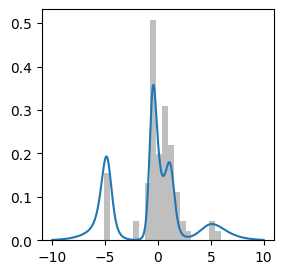

In [366]:
_, ax = plt.subplots(figsize=(3,3))

ax.hist(X.reshape(-1), color="grey", alpha=0.5, bins=20, density=True)
ax.plot(X_plot, approx_prob)

In [329]:
kernel = IMQKernel(1.)
null = kernel_exp_family(L, kef_l, q0_std=kef_q0_std)
estimator = KSDAnalyticEstimator(kernel, null)
estimator(None, X)

big_lambda_n [[ 0.10926925 -0.01898558  0.0572874   0.00991449  0.02270504]
 [-0.01898559  0.01049798 -0.0067044   0.00323491 -0.00144764]
 [ 0.05728738 -0.0067044   0.03412957  0.0090801   0.01507667]
 [ 0.00991448  0.00323491  0.0090801   0.00553043  0.00515309]
 [ 0.02270505 -0.00144764  0.01507668  0.00515309  0.00725382]]
nu_n [-0.04348493  0.04131965 -0.00364204  0.02598427  0.00794143]
eta_estimate [-0.92201036  0.47297215  3.8515208  -5.9567223  -1.3223526 ]
theta_estimate [-0.92201036  0.47297215  3.8515208  -5.9567223  -1.3223526 ]


Array([-0.92201036,  0.47297215,  3.8515208 , -5.9567223 , -1.3223526 ],      dtype=float32)

In [337]:
kernel = kernels.IMQ(sigma_sq=2*1.**2)
est_params = kef.ksd_est(X, kernel)

In [338]:
est_params

Array([-0.9219946,  0.4730076,  3.8514888, -5.956779 , -1.3222908],      dtype=float32)

In [211]:
# def sample_from_mixture(n):
#     means = [-5., 0., 5.]
#     stds = [0.1, .5, 0.1]
#     ratios = [0.1, 0.85, 0.05]
#     ns = np.random.multinomial(n, ratios, size=1).astype(np.int64)
#     X_ls = []
#     for i in range(len(means)):
#         X_ls.append(np.random.normal(loc=np.array(means[i]), scale=np.array(stds[i]), size=(ns[0][i], 1)))

#     X = np.concatenate(X_ls, 0)
#     return jnp.array(X)

In [93]:
np.random.seed(321)

add_outlier = True
n = 100
ntest = 100

# 1. pure data
X = exp_kef.sample_from_mixture(n)

# # remove "outliers"
# X = X[X < 2.5]
# X = np.reshape(X[X > -2.5], (-1, 1))

# # 2. contam data
if add_outlier:
    eps = 0.1
    ol_mean = 10.
    X = exp_efm.sample_outlier_contam(X, eps=eps, ol_mean=ol_mean, ol_std=0.1)

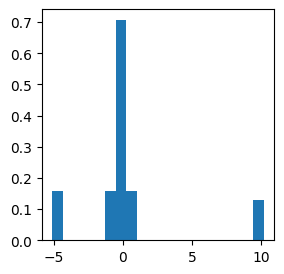

In [94]:
_, ax = plt.subplots(figsize=(3, 3))

_ = ax.hist(jnp.squeeze(X), bins=20, density=True)

In [95]:
L = 25
kef_l = jnp.sqrt(2)
kef_p0_std = 3.
params = None # np.ones((L,))
kef = exp_kef.KernelExpFamily(params=params, bw=kef_l, L=L, p0_loc=0., p0_scale=kef_p0_std)

In [96]:
# kernel = kernels.SumKernel([kernels.IMQ(sigma_sq=2*l**2) for l in [0.6, 1.0, 1.2]])
# kernel = kernels.IMQ(med_heuristic=True, X=X, Y=X)
# kernel = kernels.IMQ(sigma_sq=2*1.**2, X=X, Y=X)

# poly_weight_fn = kernels.PolyWeightFunction(a=X.std())
poly_weight_fn = kernels.PolyWeightFunction(a=1.)
kernel0 = kernels.IMQ(sigma_sq=2*1.**2, X=X, Y=X)
kernel = kernels.TiltedKernel(kernel=kernel0, weight_fn=poly_weight_fn)

est_params = kef.ksd_est(X, kernel)
print("est_params", est_params)

est_params [-9.0231603e-01 -5.7383990e+00  7.8100693e-01 -1.4161769e+00
  2.3211999e-01 -2.4199693e-01  5.8003921e-02 -5.3495731e-02
  4.3157447e-02 -5.7300705e-02  7.6365426e-02 -1.0099503e-01
  1.2820484e-01 -1.5612707e-01  1.8231705e-01 -2.0421004e-01
  2.1928085e-01 -2.2539443e-01  2.2102806e-01 -2.0552942e-01
  1.7918788e-01 -1.4324996e-01  9.9751756e-02 -5.1325954e-02
  9.0811145e-04]


In [97]:
trained_kef_model = exp_kef.KernelExpFamily(est_params, bw=kef_l, L=L, p0_loc=0., p0_scale=kef_p0_std)

In [98]:
seed = jax.random.PRNGKey(seed=56789)
X_plot = np.reshape(np.linspace(-10., 10., 1001), (-1, 1))
approx_prob = trained_kef_model.approx_prob(seed, xs=X_plot, n_samples=2000)

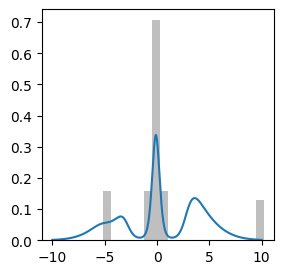

In [99]:
_, ax = plt.subplots(figsize=(3,3))
ax.hist(X.reshape(-1), color="grey", alpha=0.5, bins=20, density=True)
ax.plot(X_plot, approx_prob)

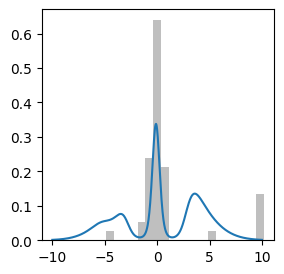

In [100]:
# # generate independent sample for testing
X_test = exp_kef.sample_from_mixture(ntest)
# X_test = sample_from_mixture(500)

if add_outlier:
    X_test = exp_efm.sample_outlier_contam(X_test, eps=eps, ol_mean=ol_mean, ol_std=0.1)

_, ax = plt.subplots(figsize=(3,3))
ax.hist(X_test.reshape(-1), color="grey", alpha=0.5, bins=20, density=True)
ax.plot(X_plot, approx_prob)

In [101]:
# # test 
# score = jax.vmap(trained_kef_model.score)(X_test)

# # test_kernel = kernel
# # test_kernel = kernels.IMQ(sigma_sq=2*1.**2, X=X, Y=X)

# poly_weight_fn = kernels.PolyWeightFunction(a=X.std())
# poly_weight_fn = kernels.PolyWeightFunction(a=X.std())
# kernel0 = kernels.IMQ(sigma_sq=2*1.**2)
# test_kernel = kernels.TiltedKernel(kernel=kernel0, weight_fn=poly_weight_fn)


# ksd = metrics.KSD(test_kernel)
# wild_boot = boot.WildBootstrap(ksd)
# pval, stat, boot_stats = wild_boot.pval(X_test, X_test, return_stat=True, return_boot=True, score=score, hvp=None)
# pval

In [102]:
# test 
score = jax.vmap(trained_kef_model.score)(X_test)

# weight_fn_args = {"a": X_test.std()}
weight_fn_args = None
theta = 0.1

X_test_b = jnp.reshape(X_test, (1, -1, 1))
score_b = jnp.reshape(score, (1, -1, 1))
test_res = exp_utils.run_tests(
    samples=X_test_b, scores=score_b, hvps=None, hvp_denom_sup=None, 
    theta=theta, bw=2.*1**2, alpha=0.05, verbose=True, base_kernel="IMQ", weight_fn_args=weight_fn_args,
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.01it/s]


In [103]:
test_res["tilted"]["pval"]

[Array(0.32667333, dtype=float32, weak_type=True)]

In [104]:
print("standard", test_res["standard"]["rej"])
print("tilted", test_res["tilted"]["rej"])
print("dev", test_res["tilted_robust_dev"]["rej"])
print("boot", test_res["tilted_robust_boot"]["rej"])

standard [0]
tilted [0]
dev [0]
boot [0]


In [59]:
print("stat", test_res["tilted_robust_boot"]["stat"])
print("threshold", test_res["tilted_robust_boot"]["threshold"])

stat [Array(0.15768242, dtype=float32)]
threshold [0.35415090382099124]


In [60]:
theta_new = 0.00001**0.5
test_res_new = copy.deepcopy(test_res)
test_res_new = exp_utils.change_theta(test_res, ["tilted_robust_dev", "tilted_robust_clt", "tilted_robust_boot"], theta_new)

In [61]:
print("dev", test_res_new["tilted_robust_dev"]["rej"])
print("boot", test_res_new["tilted_robust_boot"]["rej"])

dev [0]
boot [0]


In [75]:
tau = test_res["tilted_robust_dev"]["tau"][0]
0.01 * tau**0.5

Array(0.09433305, dtype=float32)

In [579]:
ksd = test_res["tilted_robust_dev"]["ksd_class"][0]

In [586]:
xx = jnp.array([[w] for w in [0., 1., 10., 30.]])
ss = jax.vmap(trained_kef_model.score)(xx)
ksd(xx, xx, score=ss, output_dim=2, vstat=True)

Array([[ 1.1577858e+00, -2.4974749e+00, -1.8066440e-20,  0.0000000e+00],
       [-2.4974749e+00,  8.0888834e+00, -1.3248710e-16,  0.0000000e+00],
       [-1.8066440e-20, -1.3248707e-16,  1.5360247e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  2.2207808e+00]],      dtype=float32)

In [5]:
stats_res = pickle.load(open("../data/rbm/stats_seed2024.pkl", "rb"))

eps_ls = list(stats_res.keys())

In [13]:
res_plot[0.]["standard"]

{'nonsq_stat': [Array(nan, dtype=float32),
  Array(nan, dtype=float32),
  Array(nan, dtype=float32),
  Array(nan, dtype=float32),
  Array(nan, dtype=float32),
  Array(nan, dtype=float32),
  Array(nan, dtype=float32),
  Array(nan, dtype=float32),
  Array(nan, dtype=float32),
  Array(nan, dtype=float32),
  Array(nan, dtype=float32),
  Array(nan, dtype=float32),
  Array(nan, dtype=float32),
  Array(nan, dtype=float32),
  Array(nan, dtype=float32),
  Array(nan, dtype=float32),
  Array(nan, dtype=float32),
  Array(nan, dtype=float32),
  Array(nan, dtype=float32),
  Array(nan, dtype=float32),
  Array(nan, dtype=float32),
  Array(nan, dtype=float32),
  Array(nan, dtype=float32),
  Array(nan, dtype=float32),
  Array(nan, dtype=float32),
  Array(nan, dtype=float32),
  Array(nan, dtype=float32),
  Array(nan, dtype=float32),
  Array(nan, dtype=float32),
  Array(nan, dtype=float32),
  Array(nan, dtype=float32),
  Array(nan, dtype=float32),
  Array(nan, dtype=float32),
  Array(nan, dtype=float32),


In [15]:
X_res = pickle.load(open("../data/rbm/X_res_seed2024.pkl", "rb"))
score_res = pickle.load(open("../data/rbm/score_res_seed2024.pkl", "rb"))


In [46]:
dim = X_res[0.].shape[-1]
Xs = X_res[0.][:1, 259:261]
scores = score_res[0.][:1, 259:261]
weight_fn_args = {"loc": jnp.zeros((dim,))}

res = exp_utils.run_tests(
    samples=Xs, scores=scores, hvps=None, hvp_denom_sup=None, 
    theta=1., bw="med", alpha=0.05, verbose=True, base_kernel="IMQ", weight_fn_args=weight_fn_args,
)

  0%|                                                                                                                                                                                                                    | 0/1 [00:00<?, ?it/s]

vstat nan
vstat [[      nan       nan]
 [      nan 59.953434]]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.55s/it]

vstat nan
vstat [[       nan        nan]
 [       nan 0.23846748]]
vstat nan
vstat [[       nan        nan]
 [       nan 0.23846748]]


In [47]:
Xs

Array([[[ 5.7665877 ,  3.1826012 ,  4.4085236 ,  0.27647567,
         -1.3640852 ,  3.367777  ,  1.2166333 ,  4.874395  ,
         -0.1847933 ,  0.13820758, -2.5301027 ,  0.27025354,
         -1.3535242 , -5.7465944 , -2.2326195 , -4.6883497 ,
          3.7414713 ,  4.58634   , -2.5111217 , -0.3655142 ,
         -0.583616  ,  1.6377798 ,  1.0491626 ,  4.436318  ,
         -5.0119505 , -1.6508658 ,  2.5216894 ,  7.1242914 ,
          0.42835933,  2.6563323 , -0.18112797, -1.8100184 ,
         -0.6466664 ,  1.2313658 , -2.887148  , -2.8066492 ,
          2.5442388 ,  3.8457673 , -0.9220649 , -3.179738  ,
          0.64563125,  1.4916968 , -0.42082828, -2.0150826 ,
          2.4939651 ,  4.188094  ,  1.1157998 ,  2.409333  ,
         -1.5075967 ,  3.9649072 ],
        [ 5.8015947 , -0.03570831,  2.468144  , -0.1698618 ,
         -0.10517251,  2.6381762 ,  0.5483849 ,  3.7301452 ,
          0.92150825,  1.6591265 , -0.29724112, -0.7829131 ,
         -1.8377461 , -3.3272538 , -0.20427012, -

In [48]:
scores

Array([[[        nan,         nan,         nan,         nan,
                 nan,         nan,         nan,         nan,
                 nan,         nan,         nan,         nan,
                 nan,         nan,         nan,         nan,
                 nan,         nan,         nan,         nan,
                 nan,         nan,         nan,         nan,
                 nan,         nan,         nan,         nan,
                 nan,         nan,         nan,         nan,
                 nan,         nan,         nan,         nan,
                 nan,         nan,         nan,         nan,
                 nan,         nan,         nan,         nan,
                 nan,         nan,         nan,         nan,
                 nan,         nan],
        [ 0.4122591 ,  1.940554  ,  0.8382592 , -0.66647315,
          0.39419287, -0.337986  , -0.4226968 , -0.3447733 ,
         -0.11110157, -1.0519476 ,  0.17306498, -0.30755   ,
          1.8463864 , -1.6898766 , -0.8299916 , -

In [55]:
import src.kgof_density as kgof_den
from kgof import data as kgof_data

hdim = 10

key = jax.random.key(2024)
keys = jax.random.split(key, 4)

b = jax.random.normal(keys[0], shape=(dim,))
c = jax.random.normal(keys[1], shape=(hdim,))
B = jax.random.bernoulli(keys[2], shape=(dim, hdim)).astype(jnp.float32) * 2 - 1.

rbm_sampler = kgof_data.DSGaussBernRBM(B, b, c)
rbm_model = kgof_den.GaussBernRBM(B, b, c)


In [57]:
rbm_model.grad_log(Xs[0])

Array([[        nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan],
       [ 0.4122591 ,  1.940554  ,  0.8382592 , -0.66647315,  0.39419287,
        -0.337986  , -0.4226968 , -0.3447733 , -0.11110157, -1.0519476 ,
         0.17306498, -0.30755   ,  1.8463864 , -1.6898766 , -0.8299916 ,
        -0.8158746 , -0.5560794 ,  0.1646651 ,  0.

In [60]:
np.allclose(scores[0, 1], rbm_model.grad_log(Xs[0, 1]))

True

In [68]:
XX = X_res[0.][0, 260:270]
SS = score_res[0.][0, 260:270]

SS_new = rbm_model.grad_log(XX)
np.allclose(SS, SS_new)

False

In [71]:
SS

Array([[ 0.4122591 ,  1.940554  ,  0.8382592 , -0.66647315,  0.39419287,
        -0.337986  , -0.4226968 , -0.3447733 , -0.11110157, -1.0519476 ,
         0.17306498, -0.30755   ,  1.8463864 , -1.6898766 , -0.8299916 ,
        -0.8158746 , -0.5560794 ,  0.1646651 ,  0.59007025,  0.7054361 ,
         1.1288815 ,  2.1903298 , -0.43938804,  1.7857463 , -1.4533173 ,
        -0.2106818 ,  2.7035182 ,  0.61866164,  1.3658162 ,  0.6626247 ,
        -1.5683281 , -0.8580208 ,  0.5100486 , -0.86347145,  0.9578879 ,
        -0.35907912,  0.8241067 ,  1.2549123 , -1.4615488 ,  0.53636074,
         0.06646745, -1.4242842 ,  0.6283381 , -0.37500715, -0.25813437,
         2.0943394 ,  0.99719965,  0.02774978,  0.79814124,  1.9325724 ],
       [ 0.85204697, -1.5768566 , -0.44561195,  1.5828607 ,  0.17793977,
         0.0072751 ,  0.9492024 , -1.1643267 ,  0.90639436, -0.86467886,
         0.17353901, -0.9210354 ,  1.5325754 ,  0.8933716 ,  0.05891156,
        -1.3856091 , -1.0595994 , -1.4311628 ,  0.

In [70]:
SS_new

Array([[ 0.4122591 ,  1.940554  ,  0.8382592 , -0.66647315,  0.39419287,
        -0.337986  , -0.4226968 , -0.3447733 , -0.11110157, -1.0519476 ,
         0.17306498, -0.30755   ,  1.8463864 , -1.6898766 , -0.8299916 ,
        -0.8158746 , -0.5560794 ,  0.1646651 ,  0.59007025,  0.7054361 ,
         1.1288815 ,  2.1903298 , -0.43938804,  1.7857463 , -1.4533173 ,
        -0.2106818 ,  2.7035182 ,  0.61866164,  1.3658162 ,  0.6626247 ,
        -1.5683281 , -0.8580208 ,  0.5100486 , -0.86347145,  0.9578879 ,
        -0.35907912,  0.8241067 ,  1.2549123 , -1.4615488 ,  0.53636074,
         0.06646745, -1.4242842 ,  0.6283381 , -0.37500715, -0.25813437,
         2.0943394 ,  0.99719965,  0.02774978,  0.79814124,  1.9325724 ],
       [ 0.85204697, -1.5768566 , -0.44561195,  1.5828607 ,  0.17793977,
         0.0072751 ,  0.9492024 , -1.1643267 ,  0.90639436, -0.86467886,
         0.17353901, -0.9210354 ,  1.5325754 ,  0.8933716 ,  0.05891156,
        -1.3856091 , -1.0595994 , -1.4311628 ,  0.

In [9]:
res_plot = stats_res
methods = {"standard": "IMQ", "tilted": "Tilted", "tilted_r_boot": "R-KSD-Boot", "tilted_r_bootmax": "R-KSD-BootMax"}

plot_df = {"eps": [], "nonsq_stat": [], "method": [], "rej": []}
for eps in eps_ls:
    for m, m_label in methods.items():
        rr = res_plot[eps][m]
        plot_df["nonsq_stat"].extend(np.array(rr["nonsq_stat"]).tolist())
        plot_df["eps"].extend([eps] * len(rr["nonsq_stat"]))
        
        plot_df["rej"].extend(rr["rej"])
        plot_df["method"].extend([m_label] * len(rr["nonsq_stat"]))

plot_df = pd.DataFrame(plot_df)


In [10]:
plot_df

,eps,nonsq_stat,method,rej
0,0.0,NaN,IMQ,1
1,0.0,NaN,IMQ,1
2,0.0,NaN,IMQ,1
3,0.0,NaN,IMQ,1
4,0.0,NaN,IMQ,1
...,...,...,...,...
395,0.4,0.734842,R-KSD-BootMax,0
396,0.4,0.725031,R-KSD-BootMax,0
397,0.4,NaN,R-KSD-BootMax,0
398,0.4,NaN,R-KSD-BootMax,0


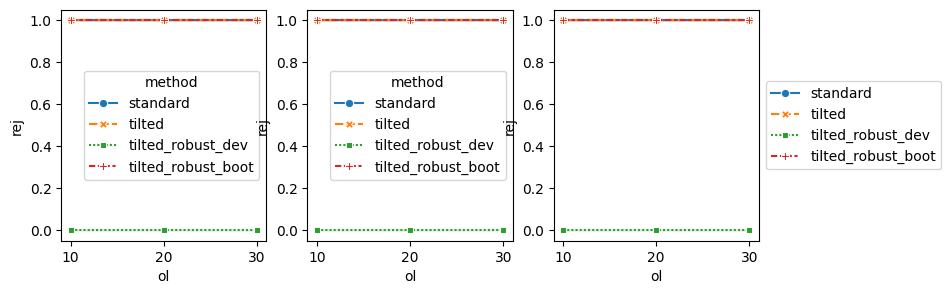

In [19]:
_, axes = plt.subplots(ncols=len(eps_ls), figsize=(3*len(eps_ls), 3))

res_plot = stats_res
method_list = ["standard", "tilted", "tilted_robust_dev", "tilted_robust_boot"]

plot_df = {"eps": [], "ol": [], "nonsq_stat": [], "nonsq_u_stat": [], "method": [], "rej": []}
for eps in eps_ls:
    for ol in ol_means_ls:
        rr = res_plot[eps][ol]["tilted"]["nonsq_stat"]
        for m in method_list:
            plot_df["nonsq_stat"] = plot_df["nonsq_stat"] + np.array(rr).tolist()
            plot_df["nonsq_u_stat"] = plot_df["nonsq_u_stat"] + (np.array(rr)**0.5).tolist()
            plot_df["eps"] = plot_df["eps"] + [eps] * len(rr)
            plot_df["ol"] = plot_df["ol"] + [ol] * len(rr)
            
            plot_df["rej"] = plot_df["rej"] + res_plot[eps][ol][m]["rej"]
            plot_df["method"] = plot_df["method"] + [m] * len(rr)

plot_df = pd.DataFrame(plot_df)

for i, ax in enumerate(axes.flatten()):
    subplot_df = plot_df.loc[plot_df.eps == eps_ls[i]]
    
    _ = sns.lineplot(ax=ax, data=subplot_df, x="ol", y="rej", hue="method", style="method", markers=True)

ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

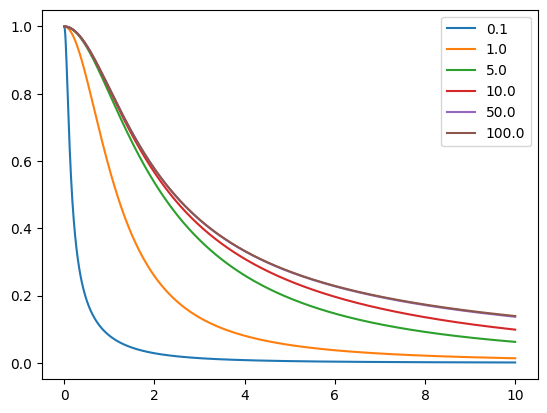

In [196]:
# weighting function
x_kernel = np.linspace(-0, 10., 1001).reshape((-1, 1))

for a in [0.1, 1., 5., 10., 50., 100.]:
    poly_weight_fn = kernels.PolyWeightFunction(a=a)
    kernel0 = kernels.IMQ(sigma_sq=2*1.**2, X=x_kernel, Y=x_kernel)
    kernel = kernels.TiltedKernel(kernel=kernel0, weight_fn=poly_weight_fn)
    
    kk_mat = kernel(x_kernel, x_kernel)
    
    _ = plt.plot(x_kernel[:, 0], kk_mat[0], label=a)

_ = plt.legend()